## The objective of this analysis file is to group the buoys by Machine Learning methods

###  In our dataset, each observation (row) has been generated by one buoy. However, the dataset doesn't provide information that relates each observation with the buoy that has created it. The only hint provided is that all observations came from roughly 70 buoys. 

### Nevertheless, the information about the latitude and longitude of each observation give us the possibility to group the observations made by location, and then, extrapolate that each different location corresponds to a different buoy. 

### Import libraries

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

from sklearn.cluster import DBSCAN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score
from sklearn.metrics import make_scorer

### Check the data

In [3]:
data = pd.read_csv('../Data/enso_data_cleaned.csv')
data['date'] = pd.to_datetime(data['date'])

In [4]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1,1980,3,7,1980-03-07,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24
1,2,1980,3,8,1980-03-08,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97
2,3,1980,3,9,1980-03-09,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28
3,4,1980,3,10,1980-03-10,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31
4,5,1980,3,11,1980-03-11,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
obs          178080 non-null int64
year         178080 non-null int64
month        178080 non-null int64
day          178080 non-null int64
date         178080 non-null datetime64[ns]
latitude     178080 non-null float64
longitude    178080 non-null float64
zon.winds    152917 non-null float64
mer.winds    152918 non-null float64
humidity     112319 non-null float64
air temp.    159843 non-null float64
s.s.temp.    161073 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 16.3 MB


### We use DBSCAN method from sklearn to cluster our observations. 
### Each cluster will correspond to one different buoy.

#### We will cluster the observations in base of their location. Thus, we define X with the longitude and latitude.

In [6]:
data['epoch_time'] = data['date'].apply(lambda x: (pd.Timestamp(x) - pd.Timestamp("1970-01-01"))//pd.Timedelta('1s'))

In [7]:
X = data[['latitude', 'longitude' , 'year']].sample(100000)

#### We set the most important parameters.

In [19]:
eps = 1.7
# The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples = 100
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

n_jobs = -1
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

#### We initialize and fit the model

In [20]:
dbs = DBSCAN(eps = eps, min_samples= min_samples, n_jobs= n_jobs)
dbs.fit(X)

DBSCAN(algorithm='auto', eps=1.7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

#### We evaluate the model using the Silhouette score.

In [21]:
# A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.
silhouette_score(X, dbs.labels_, sample_size= 50000)

0.5766114692124947

#### We add the labels from DBSCAN to a new column in the dataset.

In [22]:
X['buoy_label'] = dbs.labels_

In [23]:
len(X['buoy_label'].unique())

68

In [24]:
X['buoy_label'].value_counts().tail()

 22    300
 64    274
 65    241
 63    218
-1      68
Name: buoy_label, dtype: int64

In [25]:
X['buoy_label'].value_counts().head()

16    8562
9     4863
18    4457
14    3326
8     2838
Name: buoy_label, dtype: int64

#### We plot the coordinates together with the label.

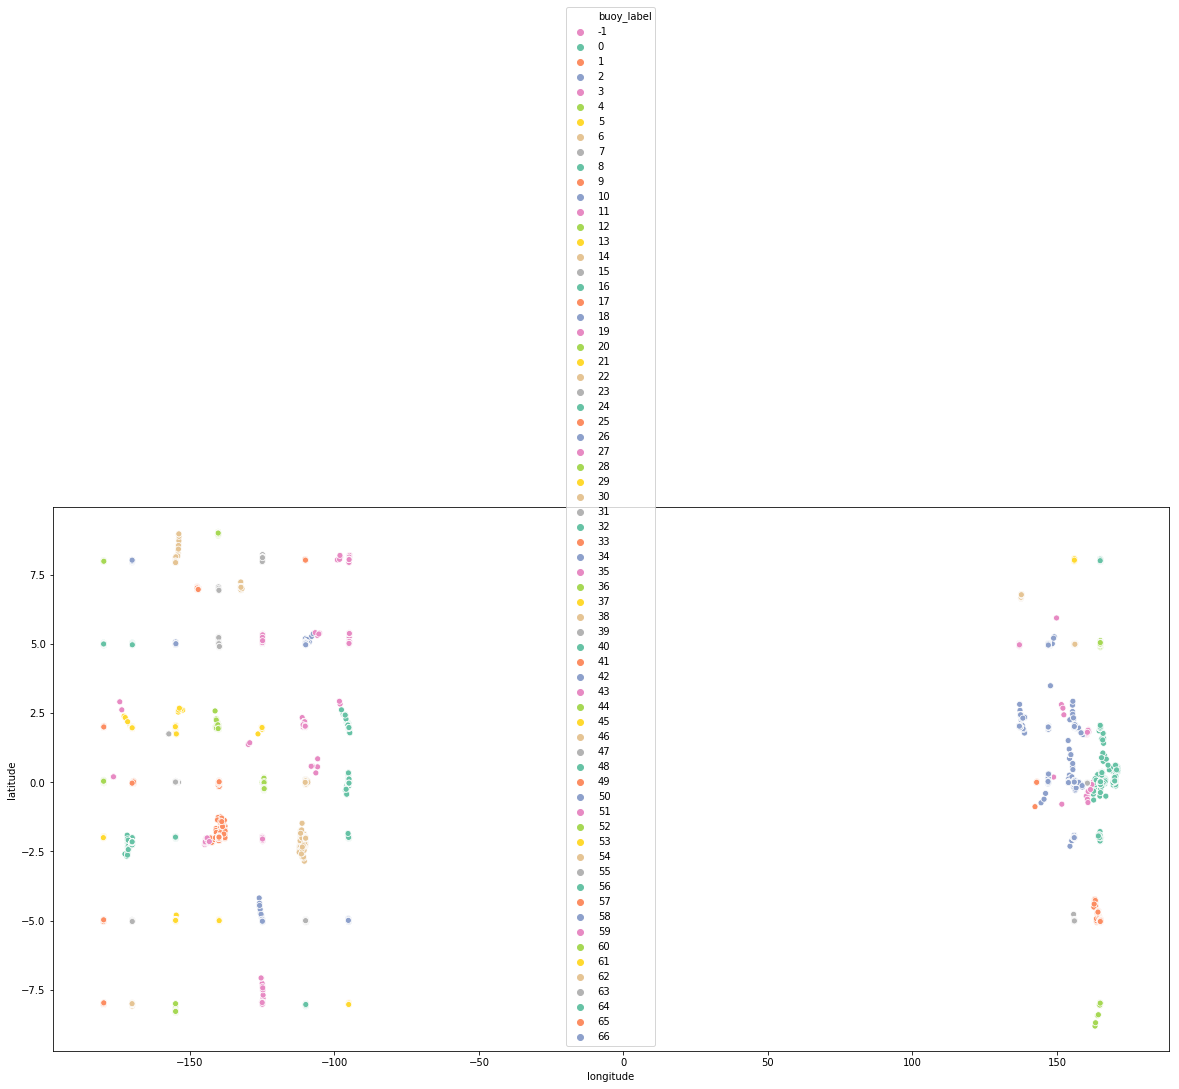

In [26]:
location = X[['latitude', 'longitude', 'buoy_label']]

x = location['longitude']
y = location['latitude']
hue = location['buoy_label']


###plot

fig, ax = plt.subplots(figsize=(20, 10))

# Label to each color
color_labels = hue.unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color = dict(zip(color_labels, rgb_values))


sns.scatterplot(x, y,  hue = hue, palette = color, legend= 'full')

### Conclusion: I cannot fit any parameter combination in the DBSCAN so all groups are well defined. The reason for this is that the shapes of the groups are very different plus there are so many groups to classify. 

#### The options that we have to cluster them all are:
- Divide & Cluster tactic.
- Try another unsupervised method for clustering.
- Take into account more dimensions.

### As a first step in the tactic "Divide & Cluster" , I next focus only in clustering the data from 4.0 to 6.0 N, because all observations in that latitude seems that are well grouped.

In [27]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,epoch_time
0,1,1980,3,7,1980-03-07,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24,321235200
1,2,1980,3,8,1980-03-08,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97,321321600
2,3,1980,3,9,1980-03-09,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28,321408000
3,4,1980,3,10,1980-03-10,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31,321494400
4,5,1980,3,11,1980-03-11,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19,321580800


In [28]:
data.shape

(178080, 13)

In [29]:
X_5 = data[(data['latitude'] < 6) & (data['latitude'] > 4)][['latitude', 'longitude' , 'year']]

In [30]:
X_5.shape

(26946, 3)

(1257, 3)


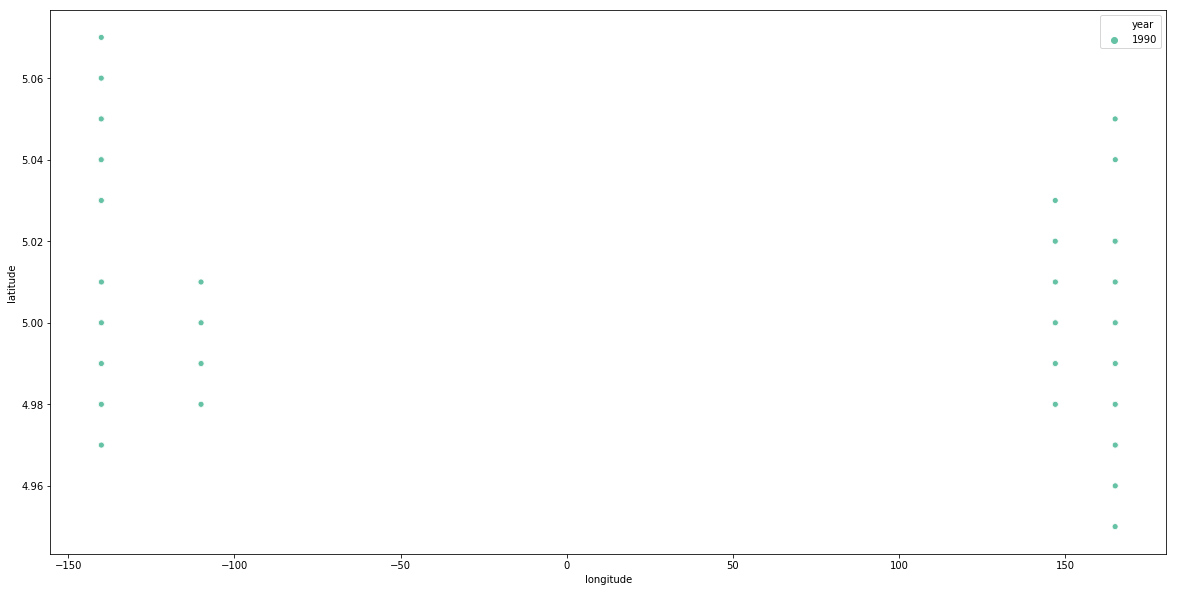

In [31]:
X_5 = data[(data['latitude'] < 6) & (data['latitude'] > 4) & (data['year'] == 1990)][['latitude', 'longitude' , 'year']]
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x = X_5['longitude'], y = X_5 ['latitude'], hue=X_5['year'], palette = 'Set2', legend= 'full')
print(X_5.shape)

#### We use DBSCAN method from sklearn to cluster our observations. 
#### Each cluster will correspond to one different buoy.

#### We set the most important parameters.

In [32]:
eps_5 = 3.0
# The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples_5 = 120
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

n_jobs_5 = -1
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

#### We initialize and fit the model

In [33]:
dbs_5 = DBSCAN(eps = eps, min_samples= min_samples, n_jobs= n_jobs)
dbs_5.fit(X_5)

DBSCAN(algorithm='auto', eps=1.7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

#### We evaluate the model using the Silhouette score.

In [34]:
# A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.
silhouette_score(X_5, dbs_5.labels_, sample_size= 50000)

0.9989762987866831

#### We add the labels from DBSCAN to a new column in the dataset.

In [35]:
X_5['buoy_label'] = dbs_5.labels_

In [36]:
len(X_5['buoy_label'].unique())

4

#### We plot the coordinates together with the label.

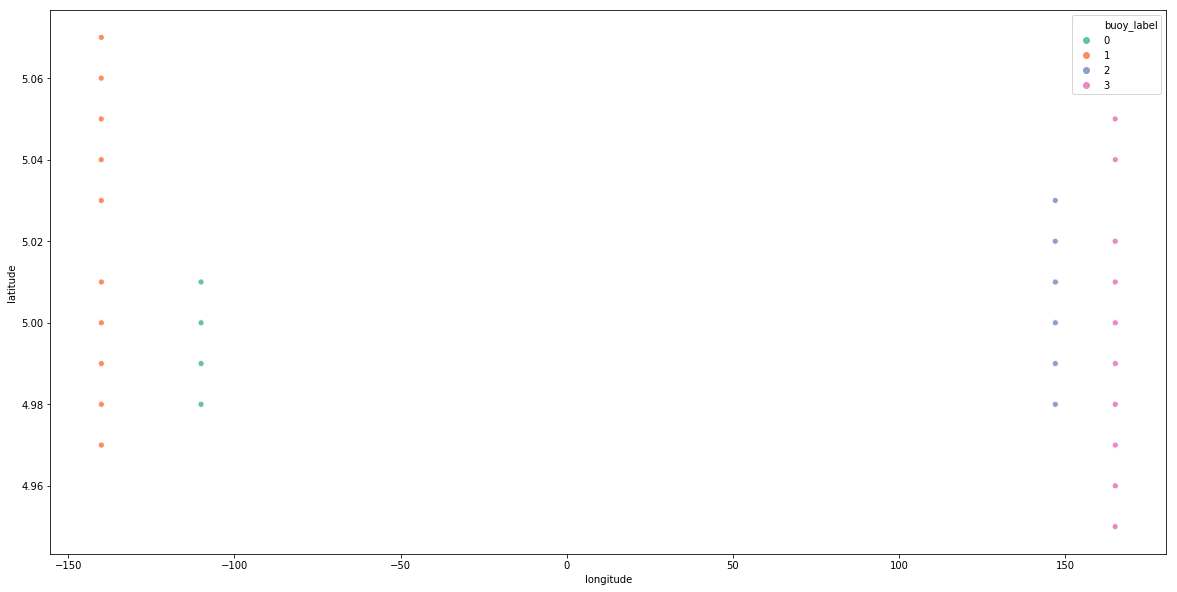

In [39]:
location = X_5[['latitude', 'longitude', 'buoy_label']]

x = location['longitude']
y = location['latitude']
hue = location['buoy_label']


###plot

fig, ax = plt.subplots(figsize=(20, 10))

# Label to each color
color_labels = hue.unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color = dict(zip(color_labels, rgb_values))


sns.scatterplot(x, y,  hue = hue, palette = color, legend= 'full')

#### We copy the well assigned observations to a new .csv.

In [69]:
data_5N.to_csv('../Data/obs_5N_labelled.csv')

### Due to lack of time, I cannot continue this 'Divide and Cluster' tactic